# Simple notebook to read the files and understand the data

In [1]:
import h5py
import numpy as np
from matplotlib import pyplot as plt

### Read the data from both files

In [2]:
# specify the path to the two files with Lyman alpha skewers, with (ON) and without (OFF) self-shielding 
fname_off='/data/desi/common/astrid/spectra_ASTRID_self-shield_off_z2.5_500x500x2500.hdf5'
fname_on='/data/desi/common/astrid/spectra_ASTRID_z2.5_500x500x2500.hdf5'

In [3]:
with h5py.File(fname_on,'r') as f:
    tau_on = f['tau/H/1/1215'][:]
    colden = f['colden']['H/1'][:]
    axes = f['spectra/axes'][:]
    # (x,y,z) start of the skewers, in kpc/h
    cofm_hkpc = f['spectra/cofm'][:]

In [4]:
with h5py.File(fname_off,'r') as f:
    tau_off = f['tau/H/1/1215'][:]
    # column densities were not stored for this file (should be the same as in the other file)
    #colden_off = f['colden']['H/1'][:]
    axes_off = f['spectra/axes'][:]
    cofm_off = f['spectra/cofm'][:]

### Play with the information describing the skewers (positions and axes)

In [5]:
# check that the axes and 2D positions of the skewers are the same in both boxes
if (np.max(axes - axes_off) > 0):
    raise ValueError('axes are not the same in both files')
if (np.max(cofm_hkpc - cofm_off) > 0):
    raise ValueError('skewers do not have the same position in both files')

In [6]:
# it turns out, all skewers were extracted along the 3rd axis
if np.min(axes) < 3:
    raise ValueError('check the value of the axes in the file')
axis=3

In [7]:
# box lenght in Mpc/h
# this information should be stored in the HDF5, but I couldn't find it... so added it by hand
L_hMpc=250
# number of skewers per side (500)
Nsk=int(np.sqrt(colden.shape[0]))
print(Nsk,'skewers per side')
# number of pixels / cells per skewer (2500)
Np=int(colden.shape[1])
print(Np,'pixels per skewer')
# pixel width (in Mpc/h)
dz_hMpc=L_hMpc/Np
print('pixel width = {:.3f} Mpc/h'.format(dz_hMpc))
# minimum separation between skewers (in Mpc/h)
dxy_hMpc=L_hMpc/Nsk
print('skewer separation = {:.3f} Mpc/h'.format(dxy_hMpc))

500 skewers per side
2500 pixels per skewer
pixel width = 0.100 Mpc/h
skewer separation = 0.500 Mpc/h


In [8]:
def skewer_index(ix, iy):
    """Given the ix, iy indices, return the global index of a given skewer"""
    return ix*Nsk+iy

In [9]:
def skewer_ix_iy(isk):
    """Given the global index, return the (ix, iy) indices of a skewer"""
    ix=isk//Nsk
    iy=isk-ix*Nsk    
    return ix, iy

In [10]:
def skewer_xy_hMpc(isk):
    """Return the (x,y) coordinates of a given skewer, in Mpc/h"""
    ix, iy = skewer_ix_iy(isk)
    return dxy_hMpc*ix, dxy_hMpc*iy

In [11]:
skewer_index(2,0)

1000

In [12]:
skewer_ix_iy(1000)

(2, 0)

In [13]:
isk=123456
x_hMpc, y_hMpc=skewer_xy_hMpc(isk)
print('skewer {} starts at position x={}, y={} Mpc/h'.format(isk, x_hMpc, y_hMpc))

skewer 123456 starts at position x=123.0, y=228.0 Mpc/h


In [14]:
print(1000, skewer_xy_hMpc(1000))

1000 (1.0, 0.0)


### Play with the column density values

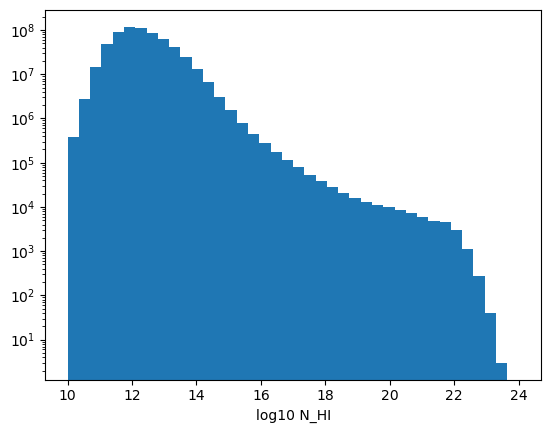

In [15]:
# there really shouldn't be any cell with N_HI=0, we will mask them for now
plt.hist(np.log10(colden[colden>0]),bins=40,range=[10,24],log=True)
plt.xlabel('log10 N_HI');

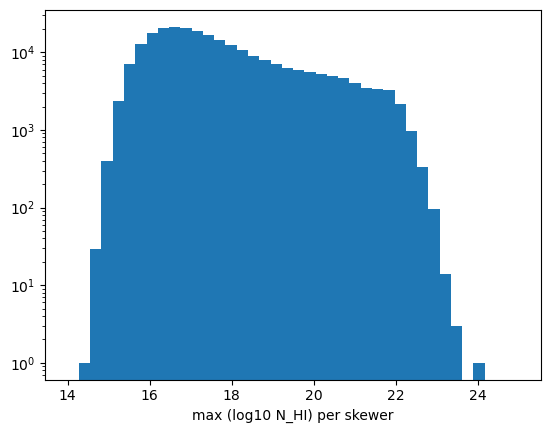

In [16]:
# 2D array with maximum column densities in skewers
max_colden=np.max(colden.reshape([Nsk,Nsk,Np]),axis=2)
plt.hist(np.log10(max_colden).flatten(),bins=40,range=[14,25],log=True)
plt.xlabel('max (log10 N_HI) per skewer');

### Play with the flux skewers 

In [17]:
# find an interesting skewer to plot (19 < log N < 20)
plot_mask = ((max_colden > 1e19) & (max_colden < 1e20)).flatten()
plot_isk=np.where(plot_mask)[0][0]
print(plot_isk)

4


In [18]:
# find the maximum colden for that skewer
idla=np.argmax(colden[plot_isk])
print(idla)

2124


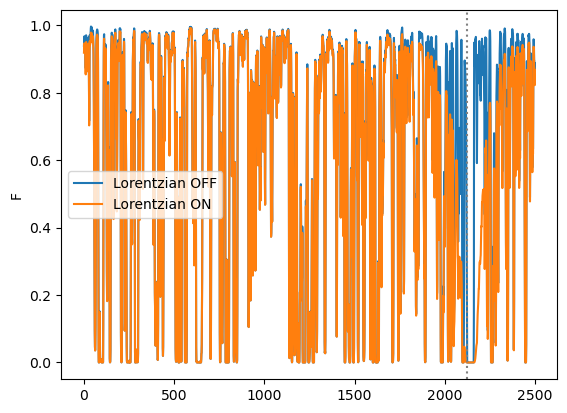

In [19]:
# plot the skewer with and without self-shielding
plt.plot(np.exp(-tau_off[plot_isk]),label='Lorentzian OFF')
plt.plot(np.exp(-tau_on[plot_isk]),label='Lorentzian ON')
plt.axvline(x=idla,ls=':',color='gray')
plt.ylabel('F')
plt.legend();

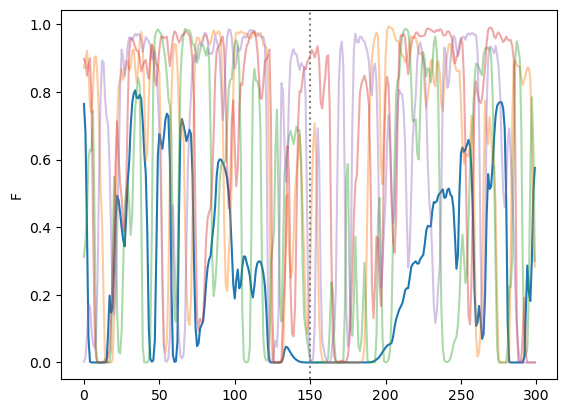

In [20]:
# plot the interesting skewer and its neighbours, around the DLA
dl=150
plot_ix, plot_iy = skewer_ix_iy(plot_isk)
plt.plot(np.exp(-tau_on[plot_isk][idla-dl:idla+dl]),label='DLA')
plot_isk_mm=skewer_index(plot_ix-1,plot_iy-1)
plot_isk_mp=skewer_index(plot_ix-1,plot_iy+1)
plot_isk_pm=skewer_index(plot_ix+1,plot_iy-1)
plot_isk_pp=skewer_index(plot_ix+1,plot_iy+1)
plt.plot(np.exp(-tau_on[plot_isk_mm])[idla-dl:idla+dl],label='(-1, -1)',alpha=0.4)
plt.plot(np.exp(-tau_on[plot_isk_mp])[idla-dl:idla+dl],label='(-1, +1)',alpha=0.4)
plt.plot(np.exp(-tau_on[plot_isk_pm])[idla-dl:idla+dl],label='(+1, -1)',alpha=0.4)
plt.plot(np.exp(-tau_on[plot_isk_pp])[idla-dl:idla+dl],label='(+1, +1)',alpha=0.4)
plt.axvline(x=dl,ls=':',color='gray')
plt.ylabel('F');
#plt.legend();

### Isolate the HCD absorption

In [21]:
print(np.min(tau_on), np.max(tau_on), np.mean(tau_on), np.mean(np.exp(-tau_on)))

0.0002143246674677357 7204517888.0 27621.401936555227 0.6063655006038974


In [22]:
print(np.min(tau_off), np.max(tau_off), np.mean(tau_off), np.mean(np.exp(-tau_off)))

3.516956348903477e-05 7204853248.0 27621.40994871812 0.6299765048134289


In [23]:
#compute the absorption caused by the Lorentzian component
tau_hcd=tau_on-tau_off

In [24]:
# plot the different contributions for an interesting skewer
new_tau=np.copy(tau_hcd[plot_isk])

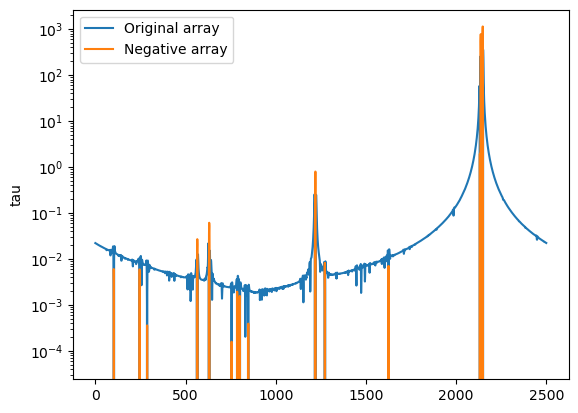

In [25]:
# plot the skewer with and without self-shielding
plt.semilogy(new_tau,label='Original array')
plt.semilogy(-new_tau,label='Negative array')
plt.ylabel('tau')
plt.legend();

It looks like there are a few numerical artefacts that we would have to deal with before we can use the tau_hcd fields

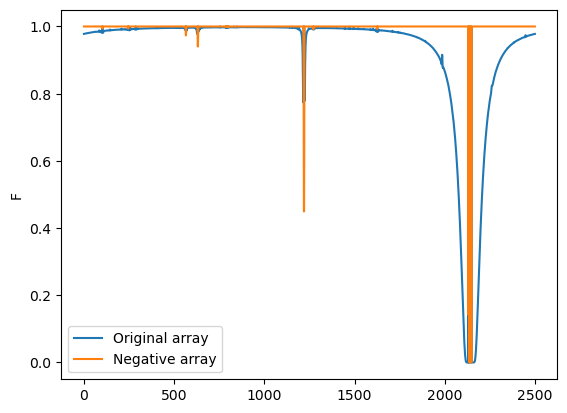

In [26]:
# plot the skewer with and without self-shielding
plt.plot(np.exp(-np.fmax(new_tau,0)),label='Original array')
plt.plot(np.exp(-np.fmax(-new_tau,0)),label='Negative array')
plt.ylabel('F')
#plt.xlim(1200,1250)
plt.legend();

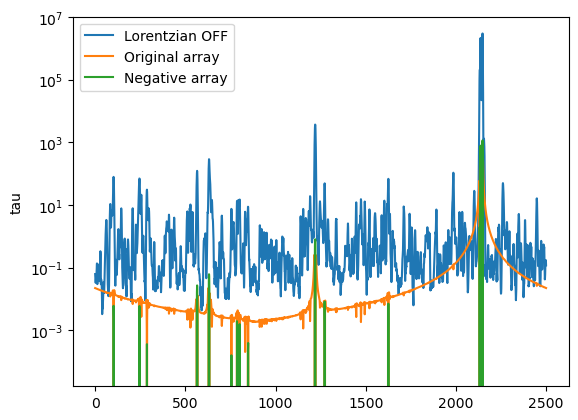

In [27]:
# plot the skewer with and without self-shielding
#plt.semilogy(tau_on[plot_isk],label='Lorentzian ON')
plt.semilogy(tau_off[plot_isk],label='Lorentzian OFF')
plt.semilogy(new_tau,label='Original array')
plt.semilogy(-new_tau,label='Negative array')
plt.ylabel('tau')
plt.legend();

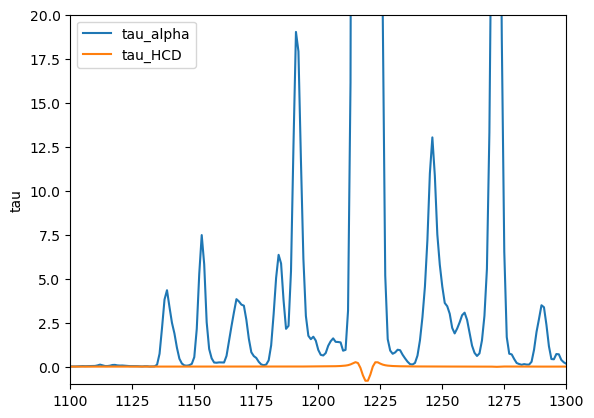

In [28]:
# plot the skewer with and without self-shielding
plt.plot(tau_off[plot_isk],label='tau_alpha')
plt.plot(new_tau,label='tau_HCD')
plt.ylabel('tau')
plt.ylim(-1,20)
plt.xlim(1100,1300)
plt.legend();

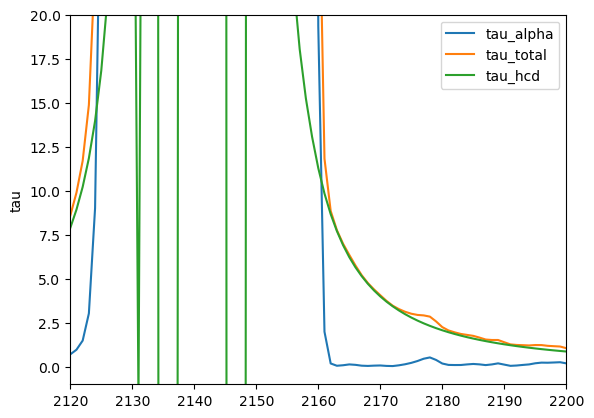

In [29]:
# plot the skewer with and without self-shielding
plt.plot(tau_off[plot_isk],label='tau_alpha')
plt.plot(tau_on[plot_isk],label='tau_total')
plt.plot(new_tau,label='tau_hcd')
plt.ylabel('tau')
plt.ylim(-1,20)
plt.xlim(2120,2200)
plt.legend();

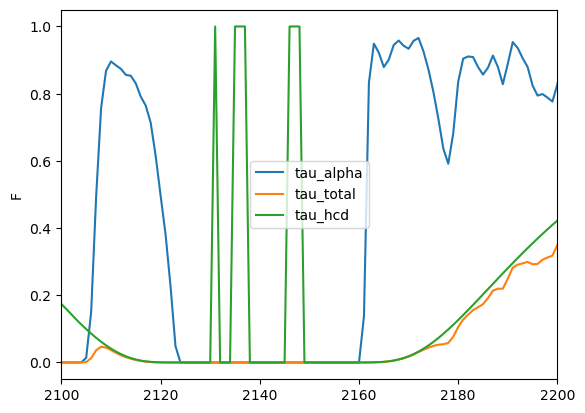

In [30]:
# plot the skewer with and without self-shielding
plt.plot(np.exp(-np.fmax(0,tau_off[plot_isk])),label='tau_alpha')
plt.plot(np.exp(-np.fmax(0,tau_on[plot_isk])),label='tau_total')
plt.plot(np.exp(-np.fmax(0,new_tau)),label='tau_hcd')
plt.ylabel('F')
#plt.ylim(-1,20)
plt.xlim(2100,2200)
plt.legend();